In [1]:
from global_variable import *

In [2]:
import random
import networkx as nx
import math
import itertools    
import matplotlib.pyplot as plt
import ast
import numpy as np
import operator

In [3]:
with open('sensornew.txt', 'r') as f:
    sensor = ast.literal_eval(f.read())

In [4]:
 sensor=sorted(sensor)

In [5]:
def distance(points,i,j):
    x=points[i][0]-points[j][0]
    y=points[i][1]-points[j][1]
    return math.sqrt(x*x+y*y)

In [6]:
def calculate_Pdp_positions(length_of_grid,transmission_range):
    pdp_positions={}
    k=0
    for c_1 in np.arange(length_of_grid/(transmission_range*math.sqrt(2))):
        for c_2 in np.arange(length_of_grid/(transmission_range*math.sqrt(2))):
            pdp_positions[k]=(c_1*transmission_range*math.sqrt(2),c_2*transmission_range*math.sqrt(2))
            k=k+1
    return pdp_positions

In [7]:
pdp_positions=calculate_Pdp_positions(length_of_grid,transmission_range)

In [8]:
def create_trip_graph():
    G=nx.Graph()
    distance_between_pdp={}
    for i in range(len(pdp_positions)):
        G.add_node('pdp{}'.format(i),pos=pdp_positions[i])
    for u in range(len(pdp_positions)):
        for v in range(len(pdp_positions)):
            wt=distance(pdp_positions,u,v)
            G.add_edge('pdp{}'.format(u),'pdp{}'.format(v),weight=wt)
            distance_between_pdp[(u,v)]=wt
    return G,distance_between_pdp

In [9]:
trip_graph,distance_between_pdp=create_trip_graph()

## From here it starts the clustering of the randomly distributed sensors in the grid

In [10]:
from sklearn.cluster import KMeans


In [11]:
s=[list(i) for i in sensor]

In [12]:
X=np.array(s)

#i chose 5 number of cluster because there were some outliers while choosing the less clusters.

In [13]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(X)


KMeans(n_clusters=5)

In [14]:
c_centers=tuple(kmeans.cluster_centers_)

In [15]:
from collections import defaultdict


In [16]:
def calculate_min_pdp_distance_with_cluster_center(c_centers,pdp_positions):
    """
    Function to calculate the nearest pdp_position to the cluster center 
    """
    new_dict={}
    for i in c_centers:
        temp={}
        for p,value in pdp_positions.items():
            arr=np.array(value)
            #print(arr)
            dist=np.linalg.norm(i-arr)
            temp[p]=dist
        #print(temp)
        print(min(temp.items(),key=operator.itemgetter(1))[0])
        print(min(temp.items(),key=operator.itemgetter(1))[1])
        print("******")
        new_dict[tuple(i)]=min(temp.items(),key=operator.itemgetter(1))[0]

    return new_dict

In [17]:
newdict=calculate_min_pdp_distance_with_cluster_center(c_centers,pdp_positions)

15
67.35631919166055
******
9
60.716477571809264
******
3
28.249707133500525
******
7
44.47276518404438
******
5
23.66755282664656
******


In [18]:
pdp_positions[7]

(141.4213562373095, 424.26406871192853)

In [19]:
newdict

{(367.0, 388.8): 15,
 (342.0, 127.75): 9,
 (7.5, 451.5): 3,
 (161.66666666666669, 384.66666666666663): 7,
 (149.0, 119.0): 5}

A trip route for drone is formed in the form of list below

In [20]:
trip_route=[]
for key,values in newdict.items():
    trip_route.append(values)


As our tour starts from the initial position 0 so 0 is added in the trip route


In [21]:
trip_route=[0]+trip_route

In [22]:
trip_route

[0, 15, 9, 3, 7, 5]

In [23]:
from itertools import combinations

In [24]:
dist = {(c1, c2): distance(pdp_positions,c1, c2) for c1, c2 in combinations(trip_route, 2)}

In [25]:
dist

{(0, 15): 600.0,
 (0, 9): 316.22776601683796,
 (0, 3): 424.26406871192853,
 (0, 7): 447.21359549995793,
 (0, 5): 200.0,
 (15, 9): 316.22776601683796,
 (15, 3): 424.26406871192853,
 (15, 7): 282.842712474619,
 (15, 5): 400.0,
 (9, 3): 400.0,
 (9, 7): 316.22776601683796,
 (9, 5): 141.4213562373095,
 (3, 7): 141.4213562373095,
 (3, 5): 316.22776601683796,
 (7, 5): 282.842712474619}

In [26]:
import gurobipy as gp
from gurobipy import GRB

In [27]:
m = gp.Model()


Restricted license - for non-production use only - expires 2022-01-13


In [28]:
vars = m.addVars(dist.keys(), obj=dist, vtype=GRB.BINARY, name='x')

In [29]:
for i, j in vars.keys():
    vars[j, i] = vars[i, j]  # edge in opposite direction

In [30]:
cons = m.addConstrs(vars.sum(c, '*') == 2 for c in trip_route)

In [31]:
def subtourelim(model, where):
    if where == GRB.Callback.MIPSOL:
        # make a list of edges selected in the solution
        vals = model.cbGetSolution(model._vars)
        selected = gp.tuplelist((i, j) for i, j in model._vars.keys()
                             if vals[i, j] > 0.5)
        # find the shortest cycle in the selected edge list
        tour = subtour(selected)
        if len(tour) < len(trip_route):
            # add subtour elimination constr. for every pair of cities in subtour
            model.cbLazy(gp.quicksum(model._vars[i, j] for i, j in combinations(tour, 2))
                         <= len(tour)-1)


In [32]:
def subtour(edges):
    unvisited = trip_route[:]
    cycle = trip_route[:] # Dummy - guaranteed to be replaced
    while unvisited:  # true if list is non-empty
        thiscycle = []
        neighbors = unvisited
        while neighbors:
            current = neighbors[0]
            thiscycle.append(current)
            unvisited.remove(current)
            neighbors = [j for i, j in edges.select(current, '*')
                         if j in unvisited]
        if len(thiscycle) <= len(cycle):
            cycle = thiscycle # New shortest subtour
    return cycle

In [33]:
m._vars = vars
m.Params.lazyConstraints = 1
m.optimize(subtourelim)

Changed value of parameter lazyConstraints to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 6 rows, 15 columns and 30 nonzeros
Model fingerprint: 0xaa61b96f
Variable types: 0 continuous, 15 integer (15 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+02, 6e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
Found heuristic solution: objective 2131.3708499
Presolve time: 0.00s
Presolved: 6 rows, 15 columns, 30 nonzeros
Variable types: 0 continuous, 15 integer (15 binary)

Root relaxation: objective 1.506177e+03, 7 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    1506.1772597 1506.17726  0.00%     -    0s

Cutting planes:
  L

In [34]:
vals = m.getAttr('x', vars)
selected = gp.tuplelist((i, j) for i, j in vals.keys() if vals[i, j] > 0.5)

tour = subtour(selected)


## This is the tour i got by using gurobi solver

In [35]:
tour

[0, 3, 7, 15, 9, 5]

In [36]:
assert len(tour) == len(trip_route)

## Here Starts the nearest neighbour solution for the TSP problem for calculating the trip time

In [37]:
def first(collection):
    "Start iterating over collection, and return the first element."
    #print("I'm here")
    return next(iter(collection))

In [38]:
def nearest_neighbor(A, cities):
    "Find the city in cities that is nearest to city A."
    distance1={}
    for j in cities:
        for key,values in distance_between_pdp.items():
            if key==(A,j):
                distance1[j]=values
               # print("Iwashere")
    minin=min(distance1)  
    return(minin)

In [39]:
def nn_tsp(cities):
    """Start the tour at the first city; at each step extend the tour 
    by moving from the previous city to its nearest neighbor 
    that has not yet been visited."""
    start = [first(cities)]
    tour = start
    print(tour)
    unvisited = set(set(cities) - set(start))
    while unvisited:
        #print("after while")
        C = nearest_neighbor(tour[-1], unvisited)
        tour.append(C)
        unvisited.remove(C)
    return tour

## This is the tour I got solving nearest neighbour solver for TSP

In [40]:
nn_solver=nn_tsp(trip_route)
nn_solver

[0]


[0, 3, 5, 7, 9, 15]

In [42]:
K=nx.DiGraph()

In [43]:
for i in range(len(sensor)):
    K.add_node('sensor{}'.format(i),pos=sensor[i])

In [44]:
def calulate_distance_between_each_sensors_and_assign_weight(points,K):
    distance_sensors={}
    M=K
    k=0
    edge_weight=1
    for i in range(len(points)):
        for j in range(len(points)):
            euclidean_distance=distance(points,i,j)
            if i!=j:
                #M.add_edge("sensor{}".format(i),"sensor{}".format(j))

                
                if euclidean_distance<=transmission_range:
                    #if M.has_edge('sensor{}'.format(i),'sensor{}'.format(j))!=True:
                    M.add_edge("sensor{}".format(i),"sensor{}".format(j))

                    M["sensor{}".format(i)]["sensor{}".format(j)]['weight']=1

                    distance_sensors[i,j]=(euclidean_distance,edge_weight)
#                 else:
#                     M["sensor{}".format(i)]["sensor{}".format(j)]['weight']=100
#                     distance_sensors[i,j]=(euclidean_distance,100)
#             k=k+1
    return distance_sensors,M

In [45]:
euclidean_distance_between_sensor,L=calulate_distance_between_each_sensors_and_assign_weight(sensor,K)

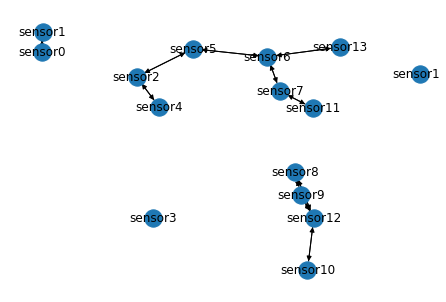

In [46]:
nx.draw(L,nx.get_node_attributes(L,'pos'),with_labels=True)

In [47]:
def distance_pdp_sensors(pdp_positions,sensor,u,v):
    x=pdp_positions[u][0]-sensor[v][0]
    y=pdp_positions[u][1]-sensor[v][1]
    return math.sqrt(x*x+y*y)

In [48]:
def connectivity_graph(pdp_positions,sensor,K):
    J=K
    distance_pdp_each_sensor={}
    k=0
    weight=1
    for i in range(len(pdp_positions)):
        J.add_node('pdp{}'.format(i),pos=pdp_positions[i])
    for u in range(len(pdp_positions)):
        for v in range(len(sensor)):
            euclidean_distance_between_pdp_sensor=distance_pdp_sensors(pdp_positions,sensor,u,v)
            J.add_edge("pdp{}".format(u),"sensor{}".format(v))
            
            if euclidean_distance_between_pdp_sensor<=transmission_range:
                #J.add_edge("pdp{}".format(u),"sensor{}".format(v))
                #if J.has_edge('pdp{}'.format(i),'sensor{}'.format(j))!=True:
                    #J.add_edge("pdp{}".format(u),"sensor{}".format(v))
               
                
                J["pdp{}".format(u)]["sensor{}".format(v)]['weight']=1
                distance_pdp_each_sensor[u,v]=euclidean_distance_between_pdp_sensor,weight
            else:
                J["pdp{}".format(u)]["sensor{}".format(v)]['weight']=100
                distance_pdp_each_sensor[u,v]=euclidean_distance_between_pdp_sensor,100
#            k=k+1
    return distance_pdp_each_sensor,J

In [49]:
distance_between_pdp_to_each_sensor,N=connectivity_graph(pdp_positions,sensor,L)

In [50]:
k=0
arc_length={}
shortest_path={}
for i in range(len(pdp_positions)):
    for j in range(len(sensor)):
        if N.has_edge('pdp{}'.format(i),'sensor{}'.format(j)):
            shortest_path[i,j]=nx.shortest_path(N,source='pdp{}'.format(i),target='sensor{}'.format(j),
                                              weight='weight',method='dijkstra')
            arc_length[i,j]=nx.dijkstra_path_length(N,'pdp{}'.format(i),'sensor{}'.format(j))
            
           
        else:
            shortest_path[i,j]=0

In [52]:
new_zipped=dict(zip(arc_length.items(),shortest_path.values()))

In [62]:
new_zipped

{((0, 0), 100): ['pdp0', 'sensor0'],
 ((0, 1), 100): ['pdp0', 'sensor1'],
 ((0, 2), 100): ['pdp0', 'sensor2'],
 ((0, 3), 100): ['pdp0', 'sensor3'],
 ((0, 4), 100): ['pdp0', 'sensor4'],
 ((0, 5), 100): ['pdp0', 'sensor5'],
 ((0, 6), 100): ['pdp0', 'sensor6'],
 ((0, 7), 100): ['pdp0', 'sensor7'],
 ((0, 8), 100): ['pdp0', 'sensor8'],
 ((0, 9), 100): ['pdp0', 'sensor9'],
 ((0, 10), 100): ['pdp0', 'sensor10'],
 ((0, 11), 100): ['pdp0', 'sensor11'],
 ((0, 12), 100): ['pdp0', 'sensor12'],
 ((0, 13), 100): ['pdp0', 'sensor13'],
 ((0, 14), 100): ['pdp0', 'sensor14'],
 ((1, 0), 100): ['pdp1', 'sensor0'],
 ((1, 1), 100): ['pdp1', 'sensor1'],
 ((1, 2), 100): ['pdp1', 'sensor2'],
 ((1, 3), 100): ['pdp1', 'sensor3'],
 ((1, 4), 100): ['pdp1', 'sensor4'],
 ((1, 5), 100): ['pdp1', 'sensor5'],
 ((1, 6), 100): ['pdp1', 'sensor6'],
 ((1, 7), 100): ['pdp1', 'sensor7'],
 ((1, 8), 100): ['pdp1', 'sensor8'],
 ((1, 9), 100): ['pdp1', 'sensor9'],
 ((1, 10), 100): ['pdp1', 'sensor10'],
 ((1, 11), 100): ['pdp1', 

In [54]:
def spanning_tree_collecting_time(pdp):
    """This function defines which sensors are connected with the desired pdp"""
    """
    return list
    """
    sensor_subset=[]
    for key,value in new_zipped.items():
        if key[0][0]==pdp:
            if key[1]!=100:
                #print(i)
                sensor_subset.append(key[0][1])
    return sensor_subset

In [58]:
def to_check_the_minimum_hops_between_the_pdp_and_sensor(spanning_tree):
    """In this function we check which sensor can send data to the pdp with minimum hops
    for example if sensor2 is connected with pdp10 with  hop distance with 2 and same sensor2 is connected with 
    pdp11 with hop distance 4 then we assume that sensor2 will send data to the drone when drone is at pdp10 since 
    it has minimum hop distance"""
    subset2=spanning_tree
    for key,value in subset2.items():
        for key1,value1 in subset2.items():
            if key!=key1:
                for i in value:
                    for j in value1:
                        if i==j:
                            #print(i)
                            #s=get_number(i)
                            if nx.dijkstra_path_length(N,'pdp{}'.format(key),'sensor{}'.format(i))>nx.dijkstra_path_length(N,'pdp{}'.format(key1),'sensor{}'.format(i)):
                                subset2[key].remove(i)
                            else:
                                subset2[key1].remove(j)
    return subset2

In [59]:
def create_spanning_tree_for_tour(tour):
    sensor_subset={}
    for i in tour:
        sensor_subset[i]=spanning_tree_collecting_time(i)
    correct_sensor_subset=to_check_the_minimum_hops_between_the_pdp_and_sensor(sensor_subset)
    return correct_sensor_subset

In [86]:
spanning_tree_nearest_nn=create_spanning_tree_for_tour(nn_solver)

In [80]:
spanning_tree_of_sensor=create_spanning_tree_for_tour(tour)

In [63]:
def calculate_collecting_time(checked_sensor_arc):
    
    weight=0
    for key,values in checked_sensor_arc.items():
        if values!=[]:
            for j in values:
                for key1,values1 in new_zipped.items():
                    if key1[0]==(key,j):
                        #print(key1[1])
                        weight=weight+key1[1]
    t_collecting=(data_rate/bandwidth)*weight
    return t_collecting
    

In [75]:
def calculate_trip_time(Route):
    """
    """
    trip_time=0
    total_route=Route+[0]
    for j in range(len(total_route)):
        if j<len(total_route)-1:
            for key,value in distance_between_pdp.items():
                if total_route[j]==key[0] and total_route[j+1]==key[1]:
                    trip_time=trip_time+(value/drone_speed)
                    print(trip_time)
    return trip_time

In [84]:
total_time_for_gurob_solver=calculate_collecting_time(spanning_tree_of_sensor)+calculate_trip_time(tour)

141.4213562373095
188.56180831641268
282.842712474619
388.251967813565
435.39241989266816
502.05908655933484


In [85]:
total_time_for_gurob_solver

557.0590865593349

In [87]:
totall_time_for_nn_solver=calculate_collecting_time(spanning_tree_nearest_nn)+calculate_trip_time(nn_solver)

141.4213562373095
246.83061157625548
341.1115157344618
446.5207710734078
551.9300264123538
751.9300264123538


In [88]:
totall_time_for_nn_solver

806.9300264123538